# Data Pipelines

#### The datasets
- Supermarket data from (Belfast City subset)
https://data.food.gov.uk/catalog/datasets/38dd8d6a-5ab1-4f50-b753-ab33288e3200. I filtered this data down to supermarkets/hypermarkets and also used open street maps api to retrieve latitude and longitude for these rows. Please read the terms of service of any api that you want to use.

- Population statistics
https://www.nisra.gov.uk/publications/postcode-district-statistics

- Bus station data
https://admin.opendatani.gov.uk/dataset/translink-bus-stop-list/resource/29f3f2fd-d131-4b86-8933-42b5b3763763

#### Data joins
If you're not familiar with joins such as inner, left, outer etc then you can take a look at this refresher: https://www.w3schools.com/sql/sql_join.asp and the pandas syntax: https://pandas.pydata.org/docs/user_guide/merging.html (see the merge section). In short:
- Inner joins two tables and keeps the rows where there is a match of the join columns in both tables
- Left/right joins two tables and but keeps all the rows in the left/right tables, even if that means leaving nulls in the joined table.
- Outer joins two tables and keeps all rows from both tables, even if that means having nulls in the joined table.

When joining tables, there's a couple of possible cases:
1. We have (or can derive) matching columns in both tables (and exists at the same granularity). This is the easy case. We will look at an example of this first.
2. We have two data tables that don't exist at the same granularity and don't have an obvious way to join them. We need to be a bit more creative typically to see what relevant information we can extract to support our analysis. We will look at an example of this secondly

In [169]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [170]:
supermarket_df = pd.read_csv("supermarkets_with_lat_long.csv").drop(["Unnamed: 0"],axis=1)

population_df = pd.read_csv("postcode_population.csv")

bus_station_df = pd.read_csv("bus_stops_belfast.csv").drop(["Unnamed: 12", "Unnamed: 13"],axis=1)

In [171]:
supermarket_df.head(2)

,FHRSID,LocalAuthorityBusinessID,BusinessName,BusinessType,BusinessTypeID,AddressLine1,AddressLine3,AddressLine4,PostCode,RatingValue,RatingKey,RatingDate,LocalAuthorityCode,LocalAuthorityName,LocalAuthorityWebSite,LocalAuthorityEmailAddress,Scores,SchemeType,NewRatingPending,Geocode,AddressLine2,lookup_address,latitude,longitude
0,1706245,269281,Alrayan supermarket,Retailers - supermarkets/hypermarkets,7840,NaN,274-276 Falls Road,Belfast,BT12 6AL,AwaitingInspection,fhrs_awaitinginspection_en-GB,NaN,807,Belfast City,http://www.belfastcity.gov.uk/buildingcontrol-...,envhealth@belfastcity.gov.uk,NaN,FHRS,False,NaN,NaN,"274-276 Falls Road, Belfast",54.584287,-5.978283
1,59480,130876,Asda,Retailers - supermarkets/hypermarkets,7840,NaN,219 Shore Road,Belfast,BT15 3PR,5,fhrs_5_en-GB,2023-10-17,807,Belfast City,http://www.belfastcity.gov.uk/buildingcontrol-...,envhealth@belfastcity.gov.uk,NaN,FHRS,False,NaN,NaN,"219 Shore Road, Belfast",54.628085,-5.922039


In [172]:
population_df.head(5)

,Postcode District,0-19,20-39,40-59,60-79,80+,All Ages
0,BT1,*,*,*,*,*,2410
1,BT2,*,*,*,*,*,1050
2,BT3,*,*,*,*,*,850
3,BT4,5910,7030,6990,4600,1440,25970
4,BT5,9220,10960,10470,6720,2140,39510


### Case 1: When we have a join key

#### Hypothesis 1 (just to motivate this example)

We want to see if certain post code areas are underserved by super markets relative to the population - ie, how many super markets are there per 1000 people in each post code area

Note: of course, there is much more that would actually matter here - your closest super market might be in a different post code, it doesn't measure smaller convenience shops etc, etc, this is just an example.

We can start by aggregating the supermarket data and then joining to the population data

In [173]:
# First we need to derive the post code area (BTx) for each row in the supermarket data
supermarket_df["post_area_code"] = supermarket_df["PostCode"].apply(lambda x: x.split(" ")[0])

In [174]:
sm_count_by_pc = supermarket_df["post_area_code"].value_counts().reset_index(drop=False)
sm_count_by_pc

,post_area_code,count
0,BT12,11
1,BT15,8
2,BT1,7
3,BT4,7
4,BT7,7
5,BT11,6
6,BT6,6
7,BT14,5
8,BT5,5
9,BT9,4


In [175]:
# Now let's join the post code population data on
market_join_population = sm_count_by_pc.merge(population_df,
                                             left_on = "post_area_code",
                                             right_on = "Postcode District",
                                             how = "left").drop(["Postcode District"],axis=1)


In [176]:
market_join_population.head(3)

,post_area_code,count,0-19,20-39,40-59,60-79,80+,All Ages
0,BT12,11,8100,9260,6860,3960,900,29090
1,BT15,8,6500,7020,7100,4550,1280,26440
2,BT1,7,*,*,*,*,*,2410


In [177]:
market_join_population["people_per_sm"] = market_join_population["All Ages"] / market_join_population["count"]

In [178]:
market_join_population.sort_values(by="people_per_sm", ascending=False)

,post_area_code,count,0-19,20-39,40-59,60-79,80+,All Ages,people_per_sm
11,BT17,3,10450,9560,8270,4790,1010,34070,11356.666667
10,BT13,3,6450,6560,5810,4120,1280,24200,8066.666667
8,BT5,5,9220,10960,10470,6720,2140,39510,7902.000000
9,BT9,4,6020,12570,5260,3600,1130,28580,7145.000000
7,BT14,5,9770,9270,8300,5040,1170,33550,6710.000000
12,BT10,2,2950,3220,3490,2390,650,12700,6350.000000
6,BT6,6,7050,9600,8290,4710,1570,31220,5203.333333
5,BT11,6,6830,7130,6930,5110,1440,27430,4571.666667
3,BT4,7,5910,7030,6990,4600,1440,25970,3710.000000
1,BT15,8,6500,7020,7100,4550,1280,26440,3305.000000


#### So based on this (rudimentary, oversimplified) analysis, it looks like BT17 is underserved with shops compared with BT12 which is a similar size.

----

### Case 2: Using data without a join key being available

#### Hypothesis 2 (again, just an example)
It may be more challenging to maintain good access to healthly food if public transport is less well connected to some areas. Let's explore that to see if some super markets are better connected to the bus network than others.

We'll take some bus station data, filter to the Belfast metro area and then, for each super market, find the distance to the nearest supermarket and also the number within a distance of (say 400m)

In [179]:
bus_station_df = bus_station_df[bus_station_df["LocalityName"] == "Belfast Metro Ops"].reset_index(drop=True)
bus_station_df = bus_station_df.sort_values(by="Latitude").reset_index(drop=True)

In [180]:
bus_station_df.head(2)

,AtcoCode,CommonName,Easting,Northing,Longitude,LocalityName,Latitude,ShortCommonName,Street,Status,Indicator,StopType
0,700000001252,Conway (River Road),328622,367433,-6.013555,Belfast Metro Ops,54.538898,NaN,NaN,active,NaN,BusCoachTramOnStreetPoint
1,700000001250,Ballybog Road,328647,367712,-6.013048,Belfast Metro Ops,54.541396,NaN,NaN,active,NaN,BusCoachTramOnStreetPoint


In [181]:
def find_nearest_bus_stop(bus_df, lat, long):
    filtered_bus_df = bus_df[(bus_df["Latitude"] > lat-0.001)&(bus_df["Latitude"] < lat+0.001)]
    if filtered_bus_df.shape[0] == 0:
        return -1
    
    min_distance = 99999
    index = -1
    for i in range(len(filtered_bus_df)):
        distance = np.sqrt(abs(lat - filtered_bus_df.iloc[i]["Latitude"])**2 + \
                           abs(long - filtered_bus_df.iloc[i]["Longitude"])**2)
        if distance < min_distance:
            min_distance = distance
            index = i
            
    return min_distance #filtered_bus_df.iloc[index]["CommonName"], min_distance

In [182]:
find_nearest_bus_stop(bus_station_df, supermarket_df.iloc[0]["latitude"], supermarket_df.iloc[0]["longitude"])

0.00044487275190515936

In [183]:
supermarket_df.iloc[33:36]

,FHRSID,LocalAuthorityBusinessID,BusinessName,BusinessType,BusinessTypeID,AddressLine1,AddressLine3,AddressLine4,PostCode,RatingValue,RatingKey,RatingDate,LocalAuthorityCode,LocalAuthorityName,LocalAuthorityWebSite,LocalAuthorityEmailAddress,Scores,SchemeType,NewRatingPending,Geocode,AddressLine2,lookup_address,latitude,longitude,post_area_code
33,58263,129955,Iceland,Retailers - supermarkets/hypermarkets,7840,NaN,162 -172 Shankill Road,Belfast,BT13 2BE,5,fhrs_5_en-GB,2020-02-27,807,Belfast City,http://www.belfastcity.gov.uk/buildingcontrol-...,envhealth@belfastcity.gov.uk,NaN,FHRS,False,NaN,NaN,"162 -172 Shankill Road, Belfast",54.605469,-5.958976,BT13
34,144385,83,Iceland,Retailers - supermarkets/hypermarkets,7840,NaN,151 Andersonstown Road,Belfast,BT11 9BH,5,fhrs_5_en-GB,2019-02-27,807,Belfast City,http://www.belfastcity.gov.uk/buildingcontrol-...,envhealth@belfastcity.gov.uk,NaN,FHRS,False,NaN,NaN,"151 Andersonstown Road, Belfast",54.577039,-5.980229,BT11
35,59602,130993,Iceland,Retailers - supermarkets/hypermarkets,7840,NaN,1 King Street,Belfast,BT1 1HU,5,fhrs_5_en-GB,2016-04-15,807,Belfast City,http://www.belfastcity.gov.uk/buildingcontrol-...,envhealth@belfastcity.gov.uk,NaN,FHRS,False,NaN,NaN,"1 King Street, Belfast",42.341409,-78.116863,BT1


In [184]:
supermarket_df['nearest_bus_dist_degrees'] = supermarket_df.apply(lambda x: find_nearest_bus_stop(bus_station_df,
                                                                              x.latitude, 
                                                                              x.longitude), axis=1)

In [185]:
supermarket_df["nearest_bus_dist_m"] = supermarket_df['nearest_bus_dist_degrees'] * 111111

In [186]:
supermarket_df[supermarket_df["nearest_bus_dist_m"]>750].head()

,FHRSID,LocalAuthorityBusinessID,BusinessName,BusinessType,BusinessTypeID,AddressLine1,AddressLine3,AddressLine4,PostCode,RatingValue,RatingKey,RatingDate,LocalAuthorityCode,LocalAuthorityName,LocalAuthorityWebSite,LocalAuthorityEmailAddress,Scores,SchemeType,NewRatingPending,Geocode,AddressLine2,lookup_address,latitude,longitude,post_area_code,nearest_bus_dist_degrees,nearest_bus_dist_m
56,59054,130451,Sainsbury's,Retailers - supermarkets/hypermarkets,7840,Holywood Exchange Retail Park,302 Airport Road West,Belfast,BT3 9EJ,5,fhrs_5_en-GB,2021-09-28,807,Belfast City,http://www.belfastcity.gov.uk/buildingcontrol-...,envhealth@belfastcity.gov.uk,NaN,FHRS,False,NaN,NaN,"302 Airport Road West, Belfast",54.625850,-5.859181,BT3,0.018059,2006.509996
75,58664,130102,Tesco,Retailers - supermarkets/hypermarkets,7840,Tesco 24hr Store,2 Knocknagoney Road,Belfast,BT4 2PW,5,fhrs_5_en-GB,2023-12-05,807,Belfast City,http://www.belfastcity.gov.uk/buildingcontrol-...,envhealth@belfastcity.gov.uk,NaN,FHRS,False,NaN,NaN,"2 Knocknagoney Road, Belfast",54.621667,-5.857236,BT4,0.007218,802.052833


In [187]:
def count_bus_stops_within_bounds(bus_df, lat, long, allowed_dist):
        filtered_bus_df = bus_df[(bus_df["Latitude"] > lat-allowed_dist)&(bus_df["Latitude"] < lat+allowed_dist)]
        filtered_bus_df = filtered_bus_df[(filtered_bus_df["Longitude"] > long-allowed_dist)&(filtered_bus_df["Longitude"] < long+allowed_dist)]
        num_bus_stops = filtered_bus_df.shape[0]
        
        return num_bus_stops
    

In [188]:
allowed_distance_m = 250
allowed_distance_deg = allowed_distance_m/111111

count_bus_stops_within_bounds(bus_station_df, 
                              supermarket_df.iloc[0]["latitude"], 
                              supermarket_df.iloc[0]["longitude"], 
                             allowed_distance_deg)

2

In [189]:
supermarket_df['num_stations_nearby'] = supermarket_df.apply(lambda x: count_bus_stops_within_bounds(bus_station_df,
                                                                                                     x.latitude, 
                                                                                                     x.longitude,
                                                                                                     allowed_distance_deg), axis=1)



In [190]:
# We can see there is a number of super markets without a nearby bus station
supermarket_df[supermarket_df["num_stations_nearby"]==0].head(4)

,FHRSID,LocalAuthorityBusinessID,BusinessName,BusinessType,BusinessTypeID,AddressLine1,AddressLine3,AddressLine4,PostCode,RatingValue,RatingKey,RatingDate,LocalAuthorityCode,LocalAuthorityName,LocalAuthorityWebSite,LocalAuthorityEmailAddress,Scores,SchemeType,NewRatingPending,Geocode,AddressLine2,lookup_address,latitude,longitude,post_area_code,nearest_bus_dist_degrees,nearest_bus_dist_m,num_stations_nearby
3,1088032,249379,Asia Supermarket,Retailers - supermarkets/hypermarkets,7840,NaN,40 Ormeau Embankment,Belfast,BT6 8LU,5,fhrs_5_en-GB,2024-02-23,807,Belfast City,http://www.belfastcity.gov.uk/buildingcontrol-...,envhealth@belfastcity.gov.uk,NaN,FHRS,False,NaN,NaN,"40 Ormeau Embankment, Belfast",54.588183,-5.918308,BT6,0.005870,652.215381,0
12,751089,220528,Co-op,Retailers - supermarkets/hypermarkets,7840,NaN,150 Kings Road,Belfast,BT5 7EJ,5,fhrs_5_en-GB,2023-07-24,807,Belfast City,http://www.belfastcity.gov.uk/buildingcontrol-...,envhealth@belfastcity.gov.uk,NaN,FHRS,False,NaN,NaN,"150 Kings Road, Belfast",54.679166,-5.913667,BT5,0.003090,343.296973,0
16,59985,131335,Co-op,Retailers - supermarkets/hypermarkets,7840,NaN,238 Antrim Road,Belfast,BT15 2AR,5,fhrs_5_en-GB,2020-02-17,807,Belfast City,http://www.belfastcity.gov.uk/buildingcontrol-...,envhealth@belfastcity.gov.uk,NaN,FHRS,False,NaN,NaN,"238 Antrim Road, Belfast",54.678716,-5.981332,BT15,0.006413,712.594135,0
31,58305,129996,Iceland,Retailers - supermarkets/hypermarkets,7840,NaN,477 Antrim Road,Belfast,BT15 3BP,5,fhrs_5_en-GB,2022-09-13,807,Belfast City,http://www.belfastcity.gov.uk/buildingcontrol-...,envhealth@belfastcity.gov.uk,NaN,FHRS,False,NaN,NaN,"477 Antrim Road, Belfast",54.678716,-5.981332,BT15,0.006413,712.594135,0


# Data transforms

Often times it's beneficial to apply some sort of transformation to our data in order to make it easier for a model to fit to. We can very broadly split this into 3 categories:

1. Null imputation - handling missing data to make sure we can still feed rows with some missing data into a model without just dropping all of those rows.
2. Feature creation - making adjustments to the data, eg, turning dates into ages or 'time since X', taking the logarithm of some features which span very large ranges.
3. Scaling the data. This is more useful for certain algorithms, for example, neural networks often benefit from values being normalised between -1 and 1 or 0 and 1 rather than between 0 and 255 (for pixel values in images).

#### Handling Nulls

In [191]:
supermarket_df.isna().sum()

FHRSID                         0
LocalAuthorityBusinessID       0
BusinessName                   0
BusinessType                   0
BusinessTypeID                 0
AddressLine1                  50
AddressLine3                   0
AddressLine4                   0
PostCode                       0
RatingValue                    0
RatingKey                      0
RatingDate                     2
LocalAuthorityCode             0
LocalAuthorityName             0
LocalAuthorityWebSite          0
LocalAuthorityEmailAddress     0
Scores                        78
SchemeType                     0
NewRatingPending               0
Geocode                       78
AddressLine2                  78
lookup_address                 0
latitude                       0
longitude                      0
post_area_code                 0
nearest_bus_dist_degrees       0
nearest_bus_dist_m             0
num_stations_nearby            0
dtype: int64

This data is pretty free of nulls generally but let's look at AddressLine1 - just as an example, let's replace those nulls with an empty string " "

In [192]:
supermarket_df["AddressLine1"] = supermarket_df["AddressLine1"].fillna(" ")

In [193]:
# check it 
supermarket_df.isna().sum()

FHRSID                         0
LocalAuthorityBusinessID       0
BusinessName                   0
BusinessType                   0
BusinessTypeID                 0
AddressLine1                   0
AddressLine3                   0
AddressLine4                   0
PostCode                       0
RatingValue                    0
RatingKey                      0
RatingDate                     2
LocalAuthorityCode             0
LocalAuthorityName             0
LocalAuthorityWebSite          0
LocalAuthorityEmailAddress     0
Scores                        78
SchemeType                     0
NewRatingPending               0
Geocode                       78
AddressLine2                  78
lookup_address                 0
latitude                       0
longitude                      0
post_area_code                 0
nearest_bus_dist_degrees       0
nearest_bus_dist_m             0
num_stations_nearby            0
dtype: int64

#### Creating features

In [194]:
supermarket_df.head(2)

,FHRSID,LocalAuthorityBusinessID,BusinessName,BusinessType,BusinessTypeID,AddressLine1,AddressLine3,AddressLine4,PostCode,RatingValue,RatingKey,RatingDate,LocalAuthorityCode,LocalAuthorityName,LocalAuthorityWebSite,LocalAuthorityEmailAddress,Scores,SchemeType,NewRatingPending,Geocode,AddressLine2,lookup_address,latitude,longitude,post_area_code,nearest_bus_dist_degrees,nearest_bus_dist_m,num_stations_nearby
0,1706245,269281,Alrayan supermarket,Retailers - supermarkets/hypermarkets,7840,,274-276 Falls Road,Belfast,BT12 6AL,AwaitingInspection,fhrs_awaitinginspection_en-GB,NaN,807,Belfast City,http://www.belfastcity.gov.uk/buildingcontrol-...,envhealth@belfastcity.gov.uk,NaN,FHRS,False,NaN,NaN,"274-276 Falls Road, Belfast",54.584287,-5.978283,BT12,0.000445,49.430256,2
1,59480,130876,Asda,Retailers - supermarkets/hypermarkets,7840,,219 Shore Road,Belfast,BT15 3PR,5,fhrs_5_en-GB,2023-10-17,807,Belfast City,http://www.belfastcity.gov.uk/buildingcontrol-...,envhealth@belfastcity.gov.uk,NaN,FHRS,False,NaN,NaN,"219 Shore Road, Belfast",54.628085,-5.922039,BT15,0.001667,185.198459,3


In [196]:
supermarket_df['RatingDate'] = pd.to_datetime(supermarket_df['RatingDate'])

In [197]:
# Define the end date
end_date = pd.to_datetime("2024-04-23")

# Function to calculate days difference
def calculate_days(date):
    if pd.isnull(date):
        return None
    else:
        return (end_date - date).days

In [198]:
calculate_days(supermarket_df.iloc[1]["RatingDate"])

189

In [199]:
supermarket_df["days_since_rating"] = supermarket_df["RatingDate"].apply(lambda x: calculate_days(x))

<AxesSubplot:>

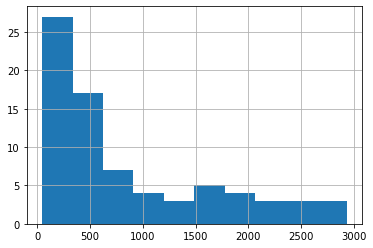

In [200]:
supermarket_df["days_since_rating"].hist()

#### Scaling

This probably isn't required for most applications of this data - but we could apply a very simple scaling to change the rating from a 1-5 scale to a 0-1 scale by dividing by 5.